# AIC-5102B Lab 2 / Text classification

The aim of this lab is to use LDA and its kernelized version to perform text classification. You should work under Linux on ESIEE's machines, where the proper execution of the lab is guaranteed.


## 1. Setup


You are free to choose the working dataset you wish to work with from Kaggle amongnst the following :
- Ecommerce Text Classification
- BBC Full Text Document Classification
- Text Classification on Emails
- Spam Text Message Classification

See https://www.kaggle.com/datasets?search=text+classification

Moreover, to alleviate the problem we will work with only 2 classes, so you will also have to choose 2 classes amongst those offered by your dataset.

You should choose a dataset which contains documents which are long enough, otherwise it is unlikely that the specialized kernel of part 4 will help. Tweets, in particular, are discouraged for that reason. If you wish to use another dataset that those mentioned above, simply ask me for validation.

Which dataset and classes did you chose ? Copy the related files to your working directory.

## 2. Text vectorization

The following functions :
- extract the vocabulary from row #5 (that number is arbitrary) of the specified CSV file 
- build the document-term matrix by reading again the same CSV file

Adapt them, so that they fit your dataset and produce a D-T matrix in the end.

Please note that:
- the tokenization method used is wordpunct_tokenize(), which may not be optimal. You may call something different in case you find really too much garbage in your resulting vocabulary.
- there are two "if" tests in dtmat_from_file which appear unnecessary so far. They are, indeed, because the test samples may include unseen words, which would generate out-of-bounds index. So unseen words are just ignored.
- you may also want to lemmatize. 

In [1]:
import csv
import nltk
import numpy as np
import sys


def voc_from_csv(csvfile):
    nlines=0
    voc=[]
    with open(csvfile, errors='ignore') as file:
        reader=csv.reader(file, delimiter=',')
        for row in reader:
            nlines=nlines+1
            voc.extend(nltk.wordpunct_tokenize(row[1]))
    voc=sorted(set(voc))        
    return voc,nlines

def dtmat_from_csv(csvfile):
    voc,rows=voc_from_csv(csvfile)
    cols=len(voc)
    mat=np.zeros((rows,cols))
    d=0
    with open(csvfile,  errors='ignore') as file:
        reader=csv.reader(file, delimiter=',')
        for row in reader:
            w= nltk.wordpunct_tokenize(row[1])
            X=np.searchsorted(voc,w,side='left')            
            for i in range(0,len(w)):
                if (X[i] < cols):
                    if (w[i] == voc[X[i]]):
                        mat[d][X[i]]+=1
            d=d+1
    return mat

### Question 1 

Run dtmat_from_csv on one of your sample dataset. Examine the resulting matrix. How many times does it happen that a given word is seen only once (possibly twice) in your training set ? Give a few lines which show this below.

In [2]:
csvfile = 'SPAM_text_message_20170820_-_Data.csv'
voc, nlines = voc_from_csv(csvfile)
dt_matrix = dtmat_from_csv(csvfile)

word_counts = np.sum(dt_matrix, axis=0)

indices_of_interest = np.where((word_counts == 1) | (word_counts == 2))[0]

print(f"Number of words to purge: {len(indices_of_interest)}")

Number of words to purge: 7630


### Question 2

Suppose we use ordinary LDA to separate positive from negative samples, computed by voc_from_csv(). What will be the effect of an increasing number of "seen only once" words :
- on the memory complexity of the solution ?
- on the solution itself ?

Write your answer below, either in plain language or using LaTeX notation for formulas if you prefer. This question is purely theoretical and does not require any programming.

### Answer

When using ordinary LDA to separate positive from negative samples, an increasing number of "seen only once" words will have the following effects:

1. Memory Complexity: The memory complexity of the solution will increase as the number of "seen only once" words increases. This is because each unique word in the vocabulary will require memory allocation to store its occurrence count in the document-term matrix.

2. Solution: The presence of a large number of "seen only once" words can have a negative impact on the solution. These words are less informative and may introduce noise in the data. As a result, the LDA model may struggle to find meaningful patterns and relationships between the positive and negative samples. This can lead to a decrease in the accuracy and effectiveness of the classification task.

In summary, an increasing number of "seen only once" words can lead to higher memory usage and potentially degrade the performance of the ordinary LDA model in separating positive from negative samples.

### Question 3

No matter what your answer to question 2 is, add a boolean parameter to voc_from_csv(), say "purge", so that when "purge" is True, the "only seen once" words are *not* included in the vocabulary. There is no need to modify dtmat_from_csv(),which has already been written to take this into account, except from the call to voc_from_csv().
Change the block below accordingly:

In [3]:
import csv
import nltk
import numpy as np
import sys

def voc_from_csv(csvfile, purge=True):
    nlines = 0
    voc = []
    word_count = {}

    with open(csvfile, errors='ignore') as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            nlines = nlines + 1
            tokens = nltk.wordpunct_tokenize(row[1])
            voc.extend(tokens)

            for token in set(tokens):
                word_count[token] = word_count.get(token, 0) + 1

    if purge:
        voc = [word for word in set(voc) if word_count[word] > 2]

    voc = sorted(voc)
    return voc, nlines

def dtmat_from_csv(csvfile):
    voc,rows=voc_from_csv(csvfile)
    cols=len(voc)
    mat=np.zeros((rows,cols))
    d=0
    with open(csvfile,  errors='ignore') as file:
        reader=csv.reader(file, delimiter=',')
        for row in reader:
            w= nltk.wordpunct_tokenize(row[1])
            X=np.searchsorted(voc,w,side='left')            
            for i in range(0,len(w)):
                if (X[i] < cols):
                    if (w[i] == voc[X[i]]):
                        mat[d][X[i]]+=1
            d=d+1
    return mat

In [4]:
csvfile = 'SPAM_text_message_20170820_-_Data.csv'
voc, nlines = voc_from_csv(csvfile, purge=True)
dt_matrix = dtmat_from_csv(csvfile)

word_counts = np.sum(dt_matrix, axis=0)

indices_of_interest = np.where((word_counts == 1) | (word_counts == 2))[0]

print(f"Number of words to purge: {len(indices_of_interest)}")

Number of words to purge: 0


## 3. Ordinary LDA

### Question 4

Write an lda(X1,X2) function which computes and returns the direction predicted by the ordinary LDA given samples X1 and X2, which should be passed as matrices of row vectors. The function should return:
- $\boldsymbol{u}$, the optimal direction
- and $s$, the abscissa of the hyperplane (the linear discriminant) on $\boldsymbol{u}$ which optimally separates the data assuming they are normally distributed after their projection on $\boldsymbol{u}$


In [17]:
import numpy as np
import matplotlib.pyplot as plt

def lda(X1, X2):
    mu1 = np.mean(X1, axis=0)
    mu2 = np.mean(X2, axis=0)
    mu = (mu1 + mu2) / 2
    
    S1 = np.cov(X1.T)
    S2 = np.cov(X2.T)
    Sw = S1 + S2

    u = np.linalg.inv(Sw) @ (mu1 - mu2)
    s = u @ mu
    
    return u, s

### Question 5

Test your function on a toy sample. Count how many points are correcly classified. You may use/extend/modify the following piece of code:

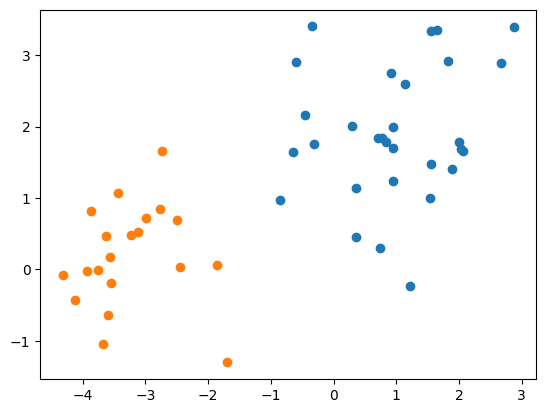

[2.70349293 0.86036528] -2.1827207832460442


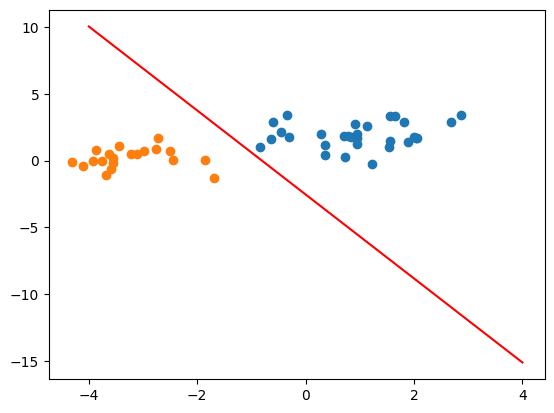

In [21]:
import matplotlib.pyplot as plt

X1=np.random.multivariate_normal([1,2], np.identity(2),30)
X2=np.random.multivariate_normal([-3,0], 0.5*np.identity(2),20)
plt.scatter(X1[:,0],X1[:,1])
plt.scatter(X2[:,0],X2[:,1])
plt.show()
u,s= lda(X1,X2)
print(u,s)
# plot the line
x = np.linspace(-4, 4, 100)
y = (s - u[0] * x) / u[1]
plt.plot(x, y, '-r', label='y=2x+1')
plt.scatter(X1[:,0],X1[:,1])
plt.scatter(X2[:,0],X2[:,1])
plt.show()

### Question 6

Test the same function on your text classes. For at least one of them (most likeley, the lightest), you should normally have a problem. Why ? Add some code to your function to fix it.

## 4. Kernelized LDA

The kernelized version of LDA is implemented as a kfda package. Its homepage is here: https://pypi.org/project/kfda/
You should install it by running pip3 install kfda

### Question 7

Let $\boldsymbol{x}$ and $\boldsymbol{y}$ be any two columns of your D-T matrix (which you may assume TD-IDF normalized or not, it does not change the problem). Consider the inhomogeneous polynomial kernel 
$$k(\boldsymbol{x},\boldsymbol{y})= (1+<\boldsymbol{x},\boldsymbol{y}>)^n$$
where $n>0$ is integer.

- Suppose that $n=2$, and that the above kernel is used in a kernelized LDA. What are the new axes created in the feature space, that didn't exist when $n=1$? Which of these could be useful, and change the solution computed by LDA in the feature space ?
- Try to classify using this setup, and report your results. Then increase $n$ (moderately). What causes the computational bottleneck of kernelized LDA ?

### Question 8

We will now slightely improve the above kernel by replacing the natural dot product 
$$<\boldsymbol{x},\boldsymbol{y}>$$ 
by 
$$ \sum_i \min(\boldsymbol{x}_i, \boldsymbol{y}_i) $$
resulting in

$$f(\boldsymbol{x},\boldsymbol{y})= (1+\sum_i \min(\boldsymbol{x}_i, \boldsymbol{y}_i) )^n$$

Is $f$ a positive semidefinite kernel ? Either prove that it is, or give a counter-example.

### Question 9

Irrespective of your answer to question 8, try kfda with $f$ as its kernel. Looking at the source code https://github.com/concavegit/kfda/blob/master/kfda/kfda.py you will notice (line 92) that it relies on the paiwise_kernels function from sklearn to compute the Gram matrix. 

According to sklearn documentation https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_kernels.html the kernel parameter can be a callable, hence you can supply a function of your own as the kernel argument, possibly using the keywords field (kwds).

Report your classification results, possibly varying $n$ (be reasonable with values, high $n$ may cause floating point exceptions, in addition of being meaningless). You should likely obtain decent (~ 75% accuracy, say) but not outstanding results.  This, however, is highly dependent on the dataset and classes you chose.

### Question 10

One reason why the obtained accuracy is not fantastic is that the vector model we are using is blind to bigrams. For instance, we may encounter (normalized) words "donald", and "trump" separately in a document, but this is very different from "donald trump".

One way to fix this is to include bigrams in the vocabulary : for two consecutive words, like "donald trump", we would add a synthetic word "donald_trump" to the vocabulary. 

What would be the memory complexity of the solution ?

### Question 11

Add an extra "bigram" parameter to voc_from_csv() to do so, and compare your results to those of question 9. Bigrams can be generated very simply using a code similar to this one:

In [ ]:
w=['I','think','traveling','to','Rio','next','winter','would','be','great']
[w[i]+'_'+w[i+1] for i in range(0,len(w)-1)]